# @Author : uzma S. L.
# '''
This notebook is a step by step implementation of siamese model for one shot learning

The sampling is done using entropy method : Here's the notebook link https://github.com/E-DBDA/Project/blob/main/best_image_extractor_for_one_shot.ipynb 




# '''

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# keras tuner for hp optimization


In [2]:
# !pip install keras-tuner 

# As we are using google colab, we need to mount the google drive to load the data file


In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tensorflow version

In [4]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [5]:
!pip install split-folders  

# importing required libraries

In [6]:
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D 
from keras.callbacks import EarlyStopping, TensorBoard 
from sklearn.model_selection import train_test_split 
from keras.models import Sequential, Model
from keras.preprocessing import image
from skimage.io import imread, imshow
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K
# from kerastuner import RandomSearch
import numpy as np
import splitfolders
import pandas as pd
import random
import os


# splitted the data into 2 test and 2 validation images

In [7]:
# splitfolders.fixed('/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images',output='/content/drive/MyDrive/Project/Data2val2test', seed=123, fixed=(2,2))

# Loading the images from the csv file we got from best images extractor to get our training data

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Project/data1 (1).csv', index_col=0)
df

,Punica Granatum (Pomegranate),Plectranthus Amboinicus (Mexican Mint),Pongamia Pinnata (Indian Beech),Syzygium Cumini (Jamun),Trigonella Foenum-graecum (Fenugreek),Syzygium Jambos (Rose Apple),Santalum Album (Sandalwood),Psidium Guajava (Guava),Piper Betle (Betel),Tabernaemontana Divaricata (Crape Jasmine),Moringa Oleifera (Drumstick),Ocimum Tenuiflorum (Tulsi),Muntingia Calabura (Jamaica Cherry-Gasagase),Hibiscus Rosa-sinensis,Jasminum (Jasmine),Murraya Koenigii (Curry),Mentha (Mint),Nerium Oleander (Oleander),Nyctanthes Arbor-tristis (Parijata),Mangifera Indica (Mango),Ficus Auriculata (Roxburgh fig),Alpinia Galanga (Rasna),Ficus Religiosa (Peepal Tree),Carissa Carandas (Karanda),Amaranthus Viridis (Arive-Dantu),Artocarpus Heterophyllus (Jackfruit),Brassica Juncea (Indian Mustard),Basella Alba (Basale),Azadirachta Indica (Neem),Citrus Limon (Lemon)
0,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...,/content/drive/MyDrive/Project/Segmented Medic...
1,4.298652633172879,3.3221615107700666,4.615524638436408,4.439326150014349,2.5401696381804224,3.2531415328004285,4.636481960348774,5.555015347156757,4.3634236525251655,4.385269525225624,3.62486665467381,4.674996548752136,4.060635261322316,3.7620791375147418,4.8209805491461175,3.971975471534751,4.382096084525976,2.4917991670313433,3.3780206205823755,2.7192748425361843,4.426628940883794,2.618494874677077,3.3611841824272357,3.7327311495204483,3.8820079378778325,4.954579610821821,4.153298058127938,5.045127282041416,3.960634858459055,4.419834065786607


In [9]:
r = df.loc[0,:]

In [10]:
# images paths
for i in r:
  print(i)

/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Punica Granatum (Pomegranate)/PG-S-054.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Plectranthus Amboinicus (Mexican Mint)/PA-S-011.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Pongamia Pinnata (Indian Beech)/PP-S-058.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Syzygium Cumini (Jamun)/SC-S-038.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Trigonella Foenum-graecum (Fenugreek)/TF-S-035.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Syzygium Jambos (Rose Apple)/SJ-S-056.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Santalum Album (Sandalwood)/SA-S-056.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-039.jpg
/content/drive/MyDrive/Project/Segmented Medicinal Leaf Images/Piper Betle (Betel)/PB-S-003.jpg
/content/drive/MyDrive/Project/Segmented Medicinal L

# Reading images from paths from csv, converting them into arrays in X and getting their labels into y 

In [11]:
data = []

label = 0
for col in df.columns:
  im = image.load_img(df.loc[0,col], target_size=(120,160))
  # img = imread(df.loc[0,col])
  # X.append(np.array(im))
  # y.append(label)
  data.append((np.array(im), label))
  label += 1

random.shuffle(data)

X = []
y = []

for img, lab in data:
  X.append(img)
  y.append(lab)

In [12]:
len(data)

30

In [13]:
data[9][1]

11

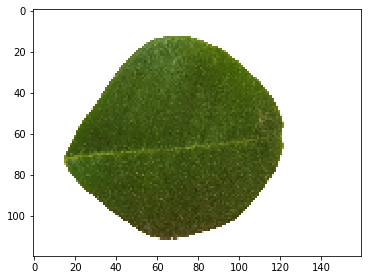

In [14]:
imshow(data[12][0]);

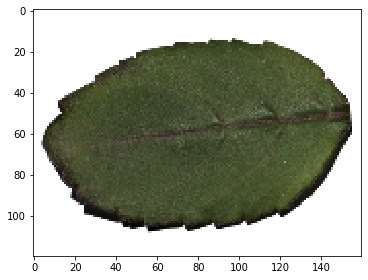

In [15]:
imshow(X[9]);

In [16]:
X = np.array(X)   # X is a list we need to convert it to array
type(X)

numpy.ndarray

In [17]:
y = np.array(y) 

In [18]:
y

array([22,  6,  7, 23, 14, 27, 20,  1, 26, 11,  9, 16, 10, 15,  5, 21,  0,
       24, 12, 29, 28,  2,  3,  8, 25,  4, 18, 17, 19, 13])

In [19]:
X = X/255  

In [20]:
X.shape, y.shape

((30, 120, 160, 3), (30,))

# now we have training data , Lets get our validation and testing data


In [21]:
def get_data(datadir):
  categories = os.listdir(datadir)
  data = []
  for category in categories:
    path = os.path.join(datadir, category)
    labels = categories.index(category)
    for imgpath in os.listdir(path):
      imgs = image.load_img(os.path.join(path, imgpath), target_size=(120,160))
      data.append((imgs, labels))
  
  random.shuffle(data)

  X_img = []
  y_lab = []

  for img , label in data:
    X_img.append(img)
    y_lab.append(label)

  X_list = [ image.img_to_array(img) for img in X_img]
  X = np.asarray(X_list)

  X /= 255

  y = np.asarray(y_lab)

  return X,y


# train_data_dir = '/content/drive/MyDrive/Project/Dataset/test'
# Xtrain, ytrain = get_data(train_data_dir)

test_data_dir = '/content/drive/MyDrive/Project/Data2val2test/test'
Xtest, ytest = get_data(test_data_dir)

val_data_dir =  '/content/drive/MyDrive/Project/Data2val2test/val'  # 2 image each class
Xval , yval = get_data(val_data_dir)

To get the below make pairs functions working lets use it for one sample

# Now we have 30 images of each class , for training a siamese network we train on pair of images , since we have small amount of data we need to create as many pairs as possibe so that our model get trained well.

## If two images are same or of the same class we will label it as 1 if they are different we will label it as 0

In [22]:
type(X)   # how we compare the similarity of two arrays?

numpy.ndarray

In [23]:
c = X[1] == X[1] 
c

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

### how do we get only single true or false?

In [24]:
r = c.all()
r

True

# now lets define a method which will compare two images and returns pair of images and its corresponding label, 1 for similar and 0 for different

In [65]:
def make_pairs(X):
  pairs = []
  labels = []

  for img in X:
    for img_other in X:
      comparison = img == img_other

      if comparison.all():
        pairs.append((img, img_other))  
        labels.append(1)
      else:
          pairs.append((img, img_other))
          labels.append(0)


  return np.array(pairs), np.array(labels)

In [66]:
pairs_train , labels_train = make_pairs(X)    # training data

In [62]:
pairs_train.shape

(900, 2, 120, 160, 3)

In [63]:
labels_train.shape

(900,)

In [64]:
labels_train

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
pairs_val , labels_val = make_pairs(Xval)   # validation data

In [31]:
pairs_test, labels_test = make_pairs(Xtest)

# Lets visualize

same images



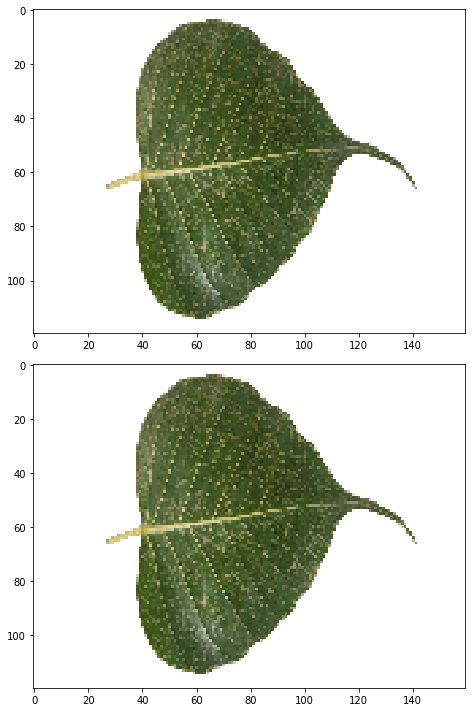

In [32]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
imshow(pairs_train[0,0]);

plt.subplot(2,1,2)
imshow(pairs_train[0,1]);

if labels_train[0]==0:
  print("different images")
else:
  print("same images")
print()

different images



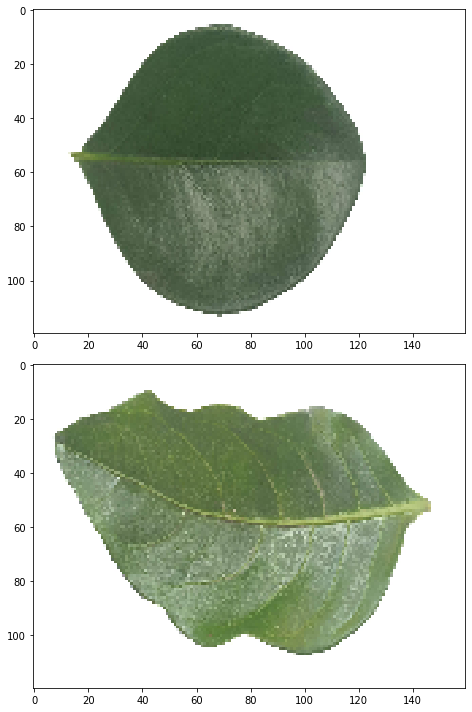

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
imshow(pairs_train[100,0]);

plt.subplot(2,1,2)
imshow(pairs_train[100,1]);

if labels_train[100]==0:
  print("different images")
else:
  print("same images")
print()

# This is how a siamese network works :
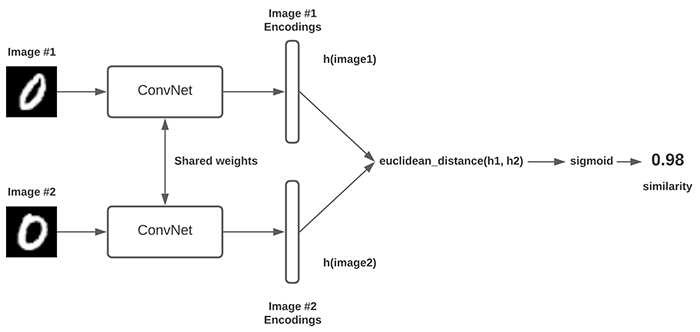

In [34]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis = 1 , keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [35]:

input_shape = (120,160,3)

def siamese_model(input_shape):
  left_inp = Input(input_shape)
  right_inp = Input(input_shape)

  model = Sequential()
  model.add(Conv2D(128, (3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D())

  model.add(Conv2D(80, (3,3), activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(112, (3,3), activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D())


  model.add(Flatten())
  
  encoded_l = model(left_inp)
  encoded_r = model(right_inp)

  L2_layer = Lambda(euclidean_distance)
  L2_distance = L2_layer([encoded_l, encoded_r])

  prediction = Dense(1, activation='sigmoid')(L2_distance)
  siamese_net = Model(inputs = [left_inp, right_inp], outputs = prediction)

  optimizer = Adam(lr = 0.0001)

  siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return siamese_net


siamese_model = siamese_model(input_shape)

siamese_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1280)         208864      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [36]:
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3,verbose=1),
              TensorBoard(log_dir=f'./logs2')
             ]

In [37]:
siamese_model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=32, epochs=5,
                  validation_data=([pairs_val[:,0], pairs_val[:,1]], labels_val[:]),
                  callbacks=callbacks)

Epoch 1/5
29/29 [==============================] - 35s 172ms/step - loss: 0.5666 - accuracy: 0.9677 - val_loss: 0.1413 - val_accuracy: 0.9833
Epoch 2/5
29/29 [==============================] - 3s 106ms/step - loss: 0.0943 - accuracy: 0.9696 - val_loss: 0.0145 - val_accuracy: 0.9833
Epoch 3/5
29/29 [==============================] - 3s 106ms/step - loss: 0.0222 - accuracy: 0.9718 - val_loss: 0.0125 - val_accuracy: 0.9833
Epoch 4/5
29/29 [==============================] - 3s 105ms/step - loss: 0.0254 - accuracy: 0.9651 - val_loss: 0.0120 - val_accuracy: 0.9833
Epoch 00004: early stopping


# Now lets test our siamese model

## Lets test on 3 images 

In [38]:
img_1 = image.load_img('/content/drive/MyDrive/Project/Data/test/Basella Alba (Basale)/BA-S-005.jpg', target_size=(120,160))
img_2 = image.load_img('/content/drive/MyDrive/Project/Data/test/Basella Alba (Basale)/BA-S-012.jpg', target_size=(120,160))
img_3 = image.load_img('/content/drive/MyDrive/Project/Data/test/Ocimum Tenuiflorum (Tulsi)/OT-S-003.jpg', target_size=(120,160))


In [39]:
img_1 = np.array(img_1)
img_2 = np.array(img_2)
img_3 = np.array(img_3)

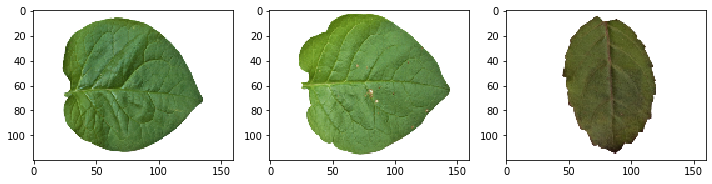

In [40]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
imshow(img_1)

plt.subplot(1,3,2)
imshow(img_2)

plt.subplot(1,3,3)
imshow(img_3);

In [41]:
img_1 = img_1 / 255
img_2 = img_2 / 255
img_3 = img_3 / 255

## making 9 pairs of above 3 test images

In [42]:
pairs_test, labels_test = make_pairs([img_1, img_2, img_3])


In [43]:
pairs_test.shape

(9, 2, 120, 160, 3)

In [44]:
pred = siamese_model.predict([pairs_test[:,0], pairs_test[:,1]])

In [45]:
pred.round(2)

array([[0.5 ],
       [0.01],
       [0.  ],
       [0.01],
       [0.5 ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.5 ]], dtype=float32)

In [46]:
labels_test

array([1, 0, 0, 0, 1, 0, 0, 0, 1])

In [47]:
siamese_model.evaluate([pairs_test[:,0], pairs_test[:,1]], labels_test[:])

1/1 [==============================] - 0s 18ms/step - loss: 0.2334 - accuracy: 0.6667


[0.2333560734987259, 0.6666666865348816]

In [68]:
%reload_ext tensorboard

In [67]:
%tensorboard --logdir logs2

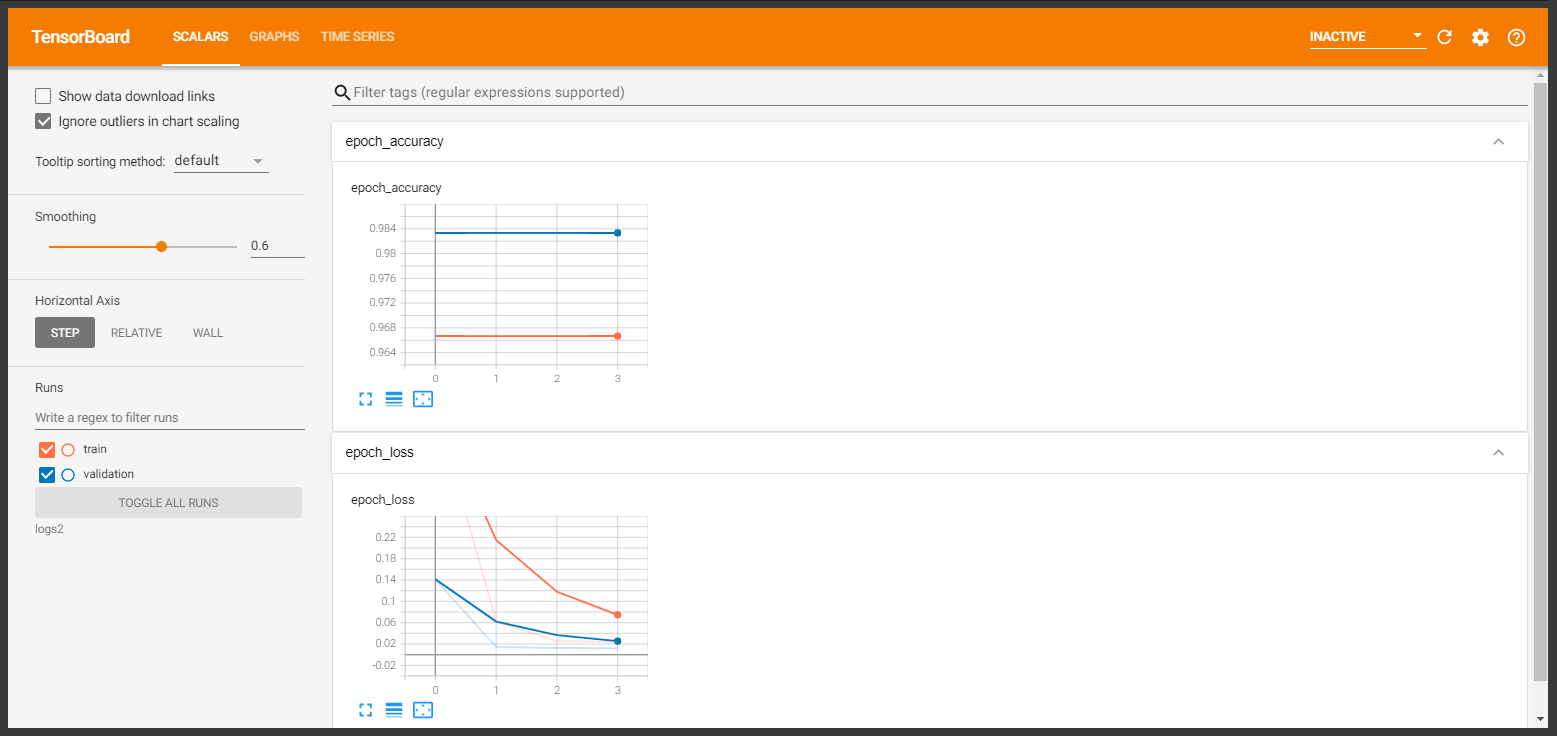

In [50]:
siamese_model.save('siamese_model.h5')

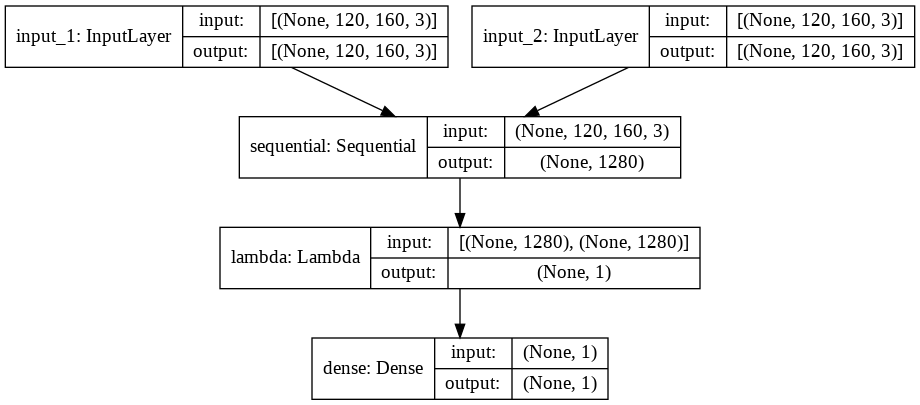

In [51]:
from keras.utils.vis_utils import plot_model

plot_model(siamese_model, to_file='/content/drive/MyDrive/Project/siamese_model.png', show_shapes=True, show_layer_names=True)